<a href="https://colab.research.google.com/github/TarkanAl-Kazily/awbw_replay_parser/blob/setup-module/AWBW_Replays_Interactive_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to my AWBW Replay Parser project!

This interactive notebook will introduce you to the replay parsing library, and demonstrate how to use it to learn more about your matches.

This notebook and the source code is all hosted on Github here: [https://github.com/TarkanAl-Kazily/awbw_replay_parser](https://github.com/TarkanAl-Kazily/awbw_replay_parser)

## Prerequisites

You will need need to have an AWBW Replay file that conforms to the newer .zip replay format. To access AWBW Replays, you must have an AWBW account and download them before they are deleted from the site. Because an account is required, it's currently not possible to automatically download replays through this notebook. Older replays _might_ work, but the results may be inaccurate.

Ideally to fully use this notebook, you have some familiarity with Python and matplotlib to to customize the displayed data from your replay. If you wish to contribute and make changes to this notebook or the repo itself, you will need a Github account and make a pull request (following the [contribution guide](https://github.com/TarkanAl-Kazily/awbw_replay_parser/blob/main/CONTRIBUTING.md)).


## Notebook Setup

In order to use the `awbw_replay_parser` code from Google Colab, we first have to clone the repository and install any missing Python modules. This block only needs to be ran once. Follow the directions to restart the kernel to take advantage of the newly installed Python modules.

If you need to install any additional Python modules, you can do so directly here with `!pip install <module>`. Note that at the time of writing, Google Colab's Python kernel version is fixed to Python 3.7.

You should be able to safely restart the Python kernel at anytime without needing to rerun this step. You only need to rerun this step if you want to pull updated changes from the Github repository.

In [ ]:
# TODO: Remove the Token steps when the Repo is made public

from getpass import getpass
import os

TOKEN = getpass('Enter Github User Token:')
os.environ['TOKEN'] = TOKEN
os.environ['REPO'] = "github.com/TarkanAl-Kazily/awbw_replay_parser.git"
os.environ['BRANCH'] = "setup-module"

# Clone the awbw_replay_parser repository
!cd /content/
!rm -rf awbw_replay_parser
!git clone --branch $BRANCH https://$TOKEN@$REPO
!pip install -r awbw_replay_parser/requirements.txt

# Install the awbw_replay module into our runtime
!cd awbw_replay_parser && python setup.py install

## Parsing a Replay

Now that the codebase is downloaded and the notebook is setup, we can start analyzing replays. To analyze your own replay, use the sidebar and upload your replay (in its original `.zip` format). Alternatively, there are a few example replays included in the repository under `awbw_replay_parser/replays/`. With Google Colab, you can also mount your Google Drive to access cloud files directly.

Power action
IMPLEMENT ME
Power action
IMPLEMENT ME
Power action
IMPLEMENT ME
Power action
IMPLEMENT ME
Resign action
IMPLEMENT ME


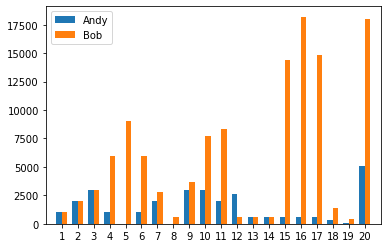

In [13]:
import awbw_replay.awbw as awbw
import awbw_replay.replay as replay
import sys
sys.path.append("awbw_replay_parser")
import main

with replay.AWBWReplay("526988.zip") as replay:
  main.test_replay(replay, show_plot=True)
